# <font color = 'red'> Momentum and Mean Reversion Strategy </font>

# <font color = 'red'> 1. Configuration </font>

In [1]:
!pip3 install ta
!pip3 install dash

Error processing line 1 of C:\Users\alver\anaconda3\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\alver\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'



Remainder of file ignored


Error processing line 1 of C:\Users\alver\anaconda3\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\alver\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


# <font color = 'red'> 1.1. Indicator Imports </font>

In [2]:
#Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

#Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

# <font color = 'red'> 1.2. Initalizing Stocks and Period </font>

In [ ]:
meta = 'META'
amazon = "AMZN"
apple = "AAPL"
netflix = 'NFLX'
google = 'GOOGL'

stockList = {meta : {}, amazon: {}, apple: {}, netflix: {}, google: {}}
defaultStockList = {meta : {}, amazon: {}, apple: {}, netflix: {}, google: {}}
stockData = {}
weight = 0.2

start = '2015-01-01'
end = '2019-12-31'

dd = yf.download([meta, amazon, apple, netflix, google], start=start, end=end)['Close']


# <font color = 'red'> 1.3. Visualizing MAANG Stock Prices from 2015 - 2019 </font>

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'MAANG Stock Closing Price from 2015 - 2019')

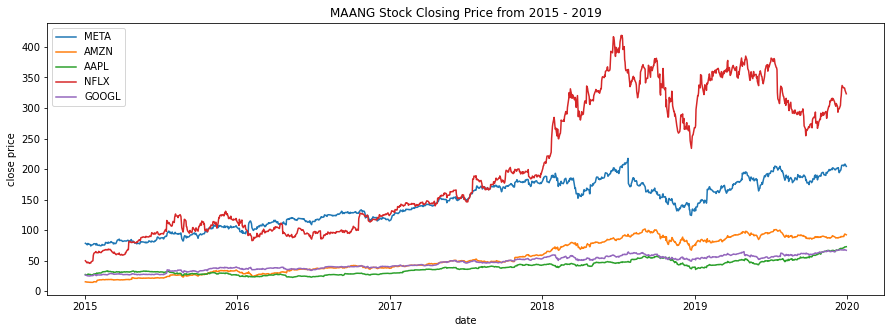

In [113]:
fig = plt.figure(figsize=(15, 5))
for stock in stockList.keys():
	hist_stock = yf.download(stock, start = start, end = end)
	stockList[stock]['info'] = hist_stock
	plt.plot(hist_stock.index, hist_stock['Close'], label=f"{stock}")
	plt.legend()

plt.xlabel('date')
plt.ylabel('close price')
plt.title('MAANG Stock Closing Price from 2015 - 2019')

<hr>

# <font color = 'red'> 2. Long/Short Strategy Logic </font>

In [114]:
def conditionGenerator(ema, bb_low, bb_high, close_price, prev):

    ## Long -- Close price < Lower band & Close price > Exponential Moving Average
    if close_price < bb_low and close_price > ema:
        return 1
    
    ## Short -- Close price > Lower band & Close price < Exponential Moving Averag
    elif close_price > bb_high and close_price < ema:
        return -1
        
    ## Other potential signals
    #elif (close_price >= bb_low and close_price <= bb_high) and close_price > ema:
    #    return 1
    
    #elif close_price < bb_low and close_price < ema: # similar
    #    return 1

    else:
        return prev

Logic:


### Long rationale:
  Price below the Lower Bollinger Band:

  When the stock's close price falls below the lower Bollinger Band, it indicates that the price is oversold, suggesting a potential buying opportunity.

  Price above the EMA:

  The Exponential Moving Average acts as a trend indicator. If the price is above the EMA, it signals that the overall trend is upward, confirming the bullish sentiment.

  Combined Rationale for Long:

  Oversold + Uptrend: The idea is to buy when the stock is oversold (below the lower Bollinger Band), but still in an uptrend (above the EMA), meaning you’re catching a pullback in a bullish market.
  This captures mean reversion, expecting the price to revert to the middle or upper Bollinger Band as it stabilizes and continues the upward trend.


### Short rationale:
  Price above the Upper Bollinger Band:

  When the stock’s close price rises above the upper Bollinger Band, it signals that the price is overbought, suggesting a potential selling opportunity.

  Price below the EMA:

  If the price is below the EMA, it confirms that the overall trend is bearish.

  Combined Rationale for Short:

  Overbought + Downtrend: The strategy shorts when the stock is overbought (above the upper Bollinger Band) but is trending lower (below the EMA). This leverages both momentum and mean reversion, expecting the price to revert downward as the larger bearish trend continues.

<hr>

### <font color = 'red'> (Variant 1) Refer to appendix (bottom) for further details </font>

# <font color = 'red'> (Variant 2) 3. Hyperparameter Search and Implementation </font>

In [115]:
pd.options.mode.chained_assignment = None

# Define the strategy function
def strategy(stock, ema_window, bb_window, bb_dev):
    # Download stock data from Yahoo Finance
    data = yf.download(stock, start=start, end=end)
    
    # Calculate the 200-day EMA
    data['EMA'] = data['Close'].ewm(span=ema_window, adjust=False).mean()

    # Calculate bollinger bands
    bollingerbands = BollingerBands(close=data['Close'], window=bb_window, window_dev=bb_dev)
    high = bollingerbands.bollinger_hband()
    low = bollingerbands.bollinger_lband()
    med = bollingerbands.bollinger_mavg()

    data['bb_high'] = high
    data['bb_low'] = low
    data['bb_mid'] = med

    # Initialize position
    data['Position'] = 0  # 1 for long, -1 for short

    # Signal generation based on EMA and BB
    for i in range(1, len(data)):
        ema = data['EMA'].iloc[i]
        bb_high = data['bb_high'].iloc[i]
        bb_low = data['bb_low'].iloc[i]
        prev = data['Position'].iloc[i-1]
        close = data['Close'].iloc[i]

        index = data.index[i]
        data.loc[index ,'Position'] = conditionGenerator(ema, bb_low, bb_high, close, prev)
    

    return data


In [116]:
def calculate_returns(data):
	"""Calculate strategy and market returns."""
	data['Market_Return'] = data['Close'].pct_change()
	data['Strategy_Return'] = data['Position'].shift(1) * data['Market_Return']
	data['Cumulative_Strategy_Return'] = (data['Strategy_Return'] + 1).cumprod() - 1
	data['Cumulative_Market_Return'] = (data['Market_Return'] + 1).cumprod() - 1
	data["Gross_Cum_Returns"] = data["Strategy_Return"].cumsum().apply(np.exp) # Same as what we did earlier to visulaise over time
	data["Cum_Max"] = data["Gross_Cum_Returns"].cummax()
	return data

## <font color = 'red'> 3.1 Grid Search to find best parameters  
### <font color = 'red'> optimize the parameters of Bollinger Bands and Exponential Moving Average to maximize the cumulative strategy returns.

In [117]:
from itertools import product

param_grid = {
    'ema_window': [100, 150, 200],
    'bb_window': [15, 20, 25], 
    'bb_dev': [1, 1.5, 2, 3]
}

def objective_function(stock, ema_window, bb_window, bb_dev):
    data = strategy(stock, ema_window, bb_window, bb_dev)
    returns_data = calculate_returns(data)
    returns = returns_data["Cumulative_Strategy_Return"]
    return returns.iloc[-1]

def grid_search(stock, param_grid):
    best_score = -np.inf
    best_params = {}

    for params in product(param_grid['ema_window'], param_grid['bb_window'], param_grid['bb_dev']):
        ema_window, bb_window, bb_dev = params
        score = objective_function(stock,ema_window, bb_window, bb_dev)

        if score > best_score:
            best_score = score
            best_params = {'ema_window': ema_window, 'bb_window':bb_window, 'bb_dev':bb_dev}

    print(f"Best Parameters: {best_params}")
    print(f"Best Total Return: {best_score}")

    return best_params

In [118]:
stockList[meta]['params'] = grid_search(meta, param_grid)
stockList[apple]['params'] = grid_search(apple, param_grid)
stockList[amazon]['params'] = grid_search(amazon, param_grid)
stockList[netflix]['params'] = grid_search(netflix, param_grid)
stockList[google]['params'] = grid_search(google, param_grid)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Best Parameters: {'ema_window': 100, 'bb_window': 25, 'bb_dev': 2}
Best Total Return: 1.5402013242360888



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Best Parameters: {'ema_window': 100, 'bb_window': 25, 'bb_dev': 3}
Best Total Return: 1.8267235215504867



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Best Parameters: {'ema_window': 200, 'bb_window': 25, 'bb_dev': 1.5}
Best Total Return: 4.041051126750149



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Best Parameters: {'ema_window': 100, 'bb_window': 15, 'bb_dev': 1}
Best Total Return: 1.944620673078739



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Best Parameters: {'ema_window': 150, 'bb_window': 20, 'bb_dev': 2}
Best Total Return: 1.4749402700485161


## <font color = 'red'> 3.2 Run strategy for each of the MAANG stocks with the best parameters from grid search

In [120]:
#Run the strategy for each MAANG stock
for stock in stockList:
    ema_window = stockList[stock]['params']['ema_window']
    bb_window = stockList[stock]['params']['bb_window']
    bb_dev = stockList[stock]['params']['bb_dev']
    stockList[stock]['strat'] = strategy(stock, ema_window, bb_window, bb_dev)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<hr>

# <font color = 'red'> 4. Trading Signals Visualisation</font>

# <font color = 'red'> 4.1. Meta Trading Signals </font>

In [122]:
stockList[meta]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,78.580002,78.930000,77.699997,78.449997,78.214500,18177500,78.449997,NaN,NaN,NaN,0
2015-01-05,77.980003,79.250000,76.860001,77.190002,76.958290,26452200,78.425047,NaN,NaN,NaN,0
2015-01-06,77.230003,77.589996,75.360001,76.150002,75.921410,27399300,78.379996,NaN,NaN,NaN,0
2015-01-07,76.760002,77.360001,75.820000,76.150002,75.921410,22045300,78.335838,NaN,NaN,NaN,0
2015-01-08,76.739998,78.230003,76.080002,78.180000,77.945312,23961000,78.332752,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,206.699997,208.589996,205.679993,206.179993,205.561066,13348900,191.910188,205.967890,194.328109,200.147999,1
2019-12-24,206.300003,206.789993,205.000000,205.119995,204.504257,6046300,192.171768,206.476497,194.437101,200.456799,1
2019-12-26,205.570007,207.820007,205.309998,207.789993,207.166229,9350700,192.481040,207.442025,194.149173,200.795599,1


# <font color = 'red'> 4.2. Apple Trading Signals </font>

In [123]:
stockList[apple]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373957,212818400,27.332500,NaN,NaN,NaN,0
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687302,257142000,27.317253,NaN,NaN,NaN,0
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689535,263188400,27.302357,NaN,NaN,NaN,0
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021706,160423600,27.295132,NaN,NaN,NaN,0
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944689,237458000,27.308545,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908981,98572000,60.799436,72.673403,62.206796,67.440100,1
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974495,48478800,61.002764,73.242055,61.981544,67.611800,1
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342972,93121200,61.229987,74.119509,61.576490,67.848000,1


# <font color = 'red'> 4.3. Amazon Trading Signals </font>

In [124]:
stockList[amazon]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000,15.426000,NaN,NaN,NaN,0
2015-01-05,15.350500,15.419000,15.042500,15.109500,15.109500,55484000,15.422850,NaN,NaN,NaN,0
2015-01-06,15.112000,15.150000,14.619000,14.764500,14.764500,70380000,15.416300,NaN,NaN,NaN,0
2015-01-07,14.875000,15.064000,14.766500,14.921000,14.921000,52806000,15.411371,NaN,NaN,NaN,0
2015-01-08,15.016000,15.157000,14.805500,15.023000,15.023000,61768000,15.407507,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,89.413002,89.650002,89.225502,89.650002,89.650002,42728000,89.058414,90.065603,86.734757,88.40018,1
2019-12-24,89.690498,89.778503,89.378998,89.460503,89.460503,17626000,89.062415,90.149499,86.797581,88.47354,1
2019-12-26,90.050499,93.523003,89.974998,93.438499,93.438499,120108000,89.105958,90.906351,86.504649,88.70550,1


# <font color = 'red'> 4.4. Netflix Trading Signals </font>

In [125]:
stockList[netflix]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000,49.848572,NaN,NaN,NaN,0
2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000,49.798331,NaN,NaN,NaN,0
2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700,49.733046,NaN,NaN,NaN,0
2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700,49.673835,NaN,NaN,NaN,0
2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900,49.636333,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,337.760010,337.950012,331.019989,333.100006,333.100006,5765300,304.222235,323.900907,296.751091,310.325999,1
2019-12-24,334.010010,335.700012,331.600006,333.200012,333.200012,2019300,304.796052,326.783115,297.474218,312.128666,1
2019-12-26,334.600006,336.459991,332.010010,332.630005,332.630005,3589900,305.347219,329.350475,298.681524,314.015999,1


# <font color = 'red'> 4.5. Google Trading Signals </font>

In [126]:
stockList[google]['strat']

,Open,High,Low,Close,Adj Close,Volume,EMA,bb_high,bb_low,bb_mid,Position
Date,,,,,,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.412100,26480000,26.477501,NaN,NaN,NaN,0
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.908844,41182000,26.470819,NaN,NaN,NaN,0
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.269430,54456000,26.455735,NaN,NaN,NaN,0
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.195112,46918000,26.439864,NaN,NaN,NaN,0
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.282898,73054000,26.425370,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,67.936501,68.092499,67.400002,67.531502,67.364700,19936000,61.878991,68.835142,64.440007,66.637574,1
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.055450,13468000,61.949752,68.854069,64.615030,66.734549,1
2019-12-26,67.327499,68.160004,67.275497,68.123497,67.955231,23662000,62.031524,68.998730,64.717718,66.858224,1


# <font color = 'red'> 4.6. Buy/Sell Signal of Stock </font>

META ================================================


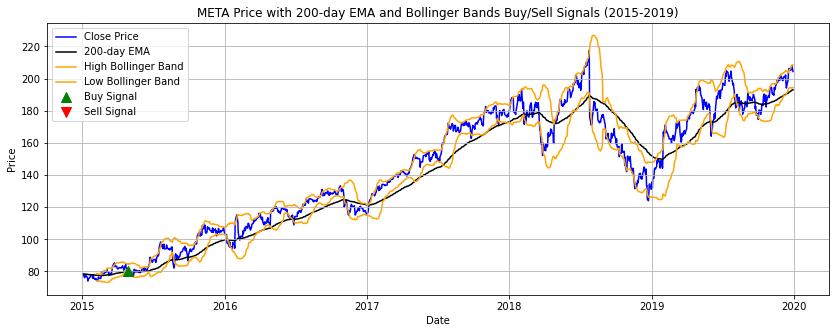

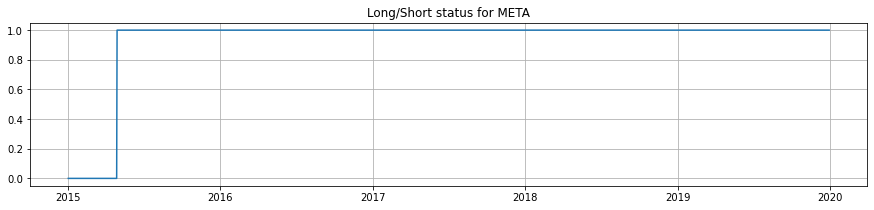

AMZN ================================================


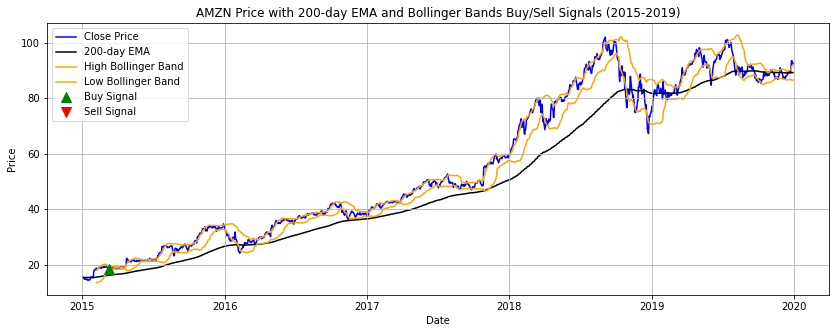

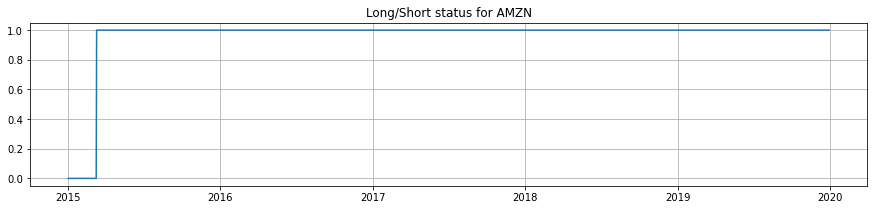

AAPL ================================================


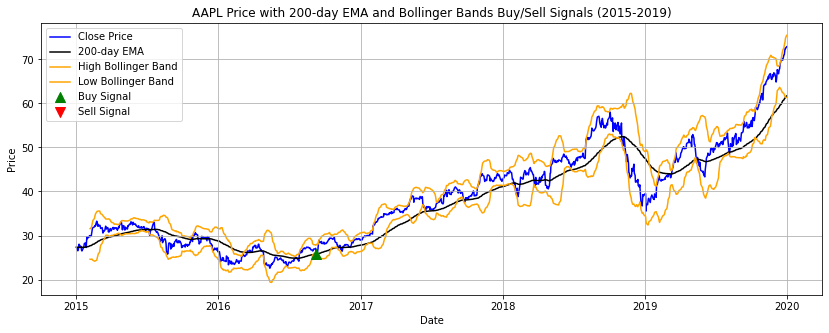

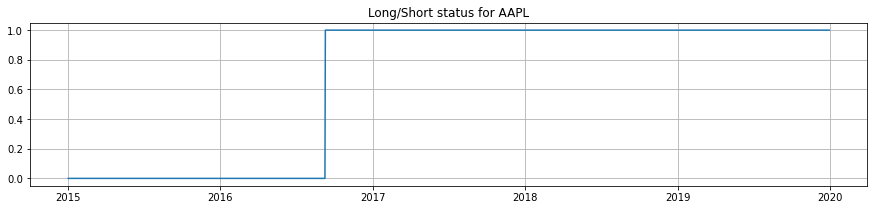

NFLX ================================================


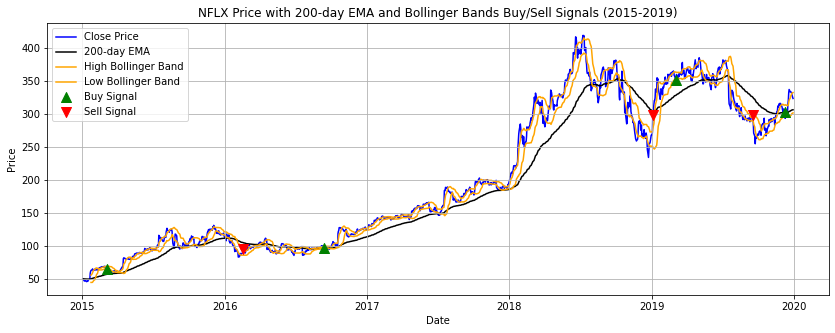

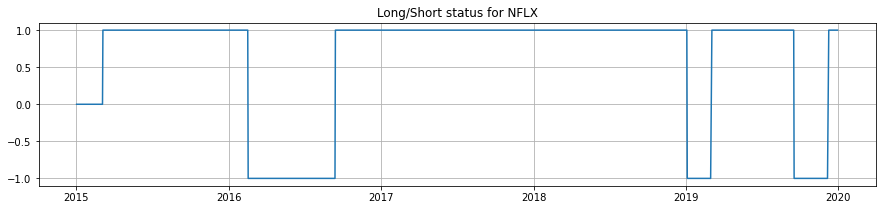

GOOGL ================================================


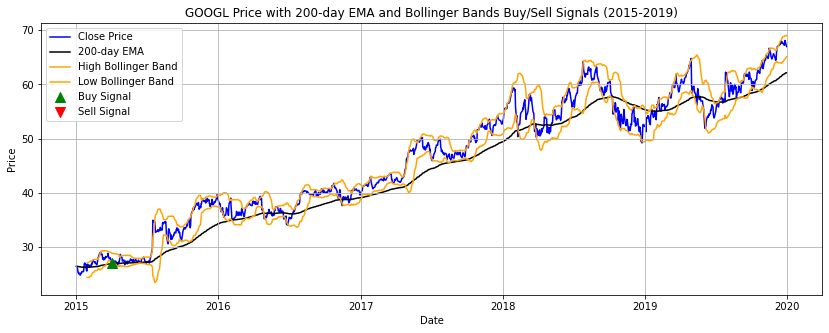

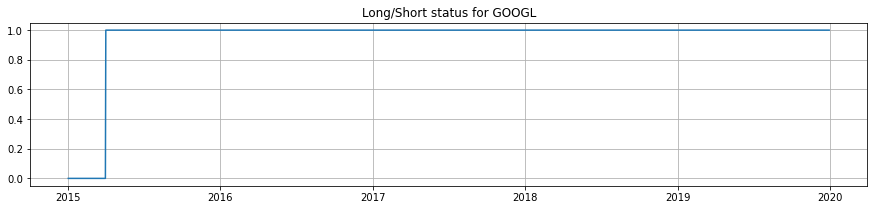

In [127]:
for stock in stockList:
	print(f"{stock} ================================================")
	# Visualization of price, 200-day EMA, and buy/sell signals
	plt.figure(figsize=(14, 5))
	plt.plot(stockList[stock]['strat']['Close'], label='Close Price', color='blue', zorder=1)
	plt.plot(stockList[stock]['strat']['EMA'], label='200-day EMA', color='black', zorder=1)
	plt.plot(stockList[stock]['strat']['bb_high'], label='High Bollinger Band', color='orange', zorder=1)
	plt.plot(stockList[stock]['strat']['bb_low'], label='Low Bollinger Band', color='orange', zorder=1)
	#plt.plot(stockList[google]['strat']['bb_mid'], label='20 Day Moving Average', color='black')

	buy_signals = stockList[stock]['strat'][(stockList[stock]['strat']['Position'] == 1) & (stockList[stock]['strat']['Position'].shift(1) != 1)]

	plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100, zorder=2)

	# Plot Sell signals (MACD cross above zero and price below 200 EMA)
	sell_signals = stockList[stock]['strat'][(stockList[stock]['strat']['Position'] == -1) & (stockList[stock]['strat']['Position'].shift(1) != -1)]
	plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100, zorder=2)

	plt.title(f'{stock} Price with 200-day EMA and Bollinger Bands Buy/Sell Signals (2015-2019)')
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.legend()
	plt.grid()
	plt.show()

	bt_data = stockList[stock]['strat']
	plt.figure(figsize=(15, 3))
	plt.plot(bt_data["Position"])
	plt.title(f"Long/Short status for {stock}")
	plt.grid()
	plt.show()


# <font color = 'red'> 4.6.1. Detailed View of Signals by Stock </font>

In [128]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd

app = dash.Dash(__name__)

# Dropdown options for stock selection
stock_options = [{'label': stock, 'value': stock} for stock in stockList.keys()]

# App layout
app.layout = html.Div(
    style={'display': 'flex', 'flexDirection': 'column', 'height': '100vh', 'padding': '10px'},
    children=[
        # Dropdown to select a stock
        dcc.Dropdown(
            id='stock-dropdown',
            options=stock_options,
            value=list(stockList.keys())[0], 
            clearable=False
        ),
        
        # can fit into 1 view by uncommenting but becomes a bit cluttered
        # Graph to display the stock chart (with price, EMA, and Bollinger Bands)
        dcc.Graph(
            id='stock-chart',
            #style={'flex': '1', 'height': '50%'}  # Take up half of the available height
        ),
        
        # Graph to display the Long/Short position status
        dcc.Graph(
            id='position-status',
            #style={'flex': '1', 'height': '50%'}  # Take up half of the available height
        )
    ]
)

# Callback to update the graphs when the dropdown value changes
@app.callback(
    [Output('stock-chart', 'figure'), Output('position-status', 'figure')],
    [Input('stock-dropdown', 'value')]
)
def update_graphs(selected_stock):
    # Get the data for the selected stock
    stock_data = stockList[selected_stock]['strat']

    # Create traces for the Close Price, EMA, and Bollinger Bands
    traces = [
        go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Close Price', line=dict(color='blue')),
        go.Scatter(x=stock_data.index, y=stock_data['EMA'], mode='lines', name='200-day EMA', line=dict(color='black')),
        go.Scatter(x=stock_data.index, y=stock_data['bb_high'], mode='lines', name='High Bollinger Band', line=dict(color='orange')),
        go.Scatter(x=stock_data.index, y=stock_data['bb_low'], mode='lines', name='Low Bollinger Band', line=dict(color='orange'))
    ]

    # Plot Buy Signals
    buy_signals = stock_data[(stock_data['Position'] == 1) & (stock_data['Position'].shift(1) != 1)]
    traces.append(go.Scatter(
        x=buy_signals.index, y=buy_signals['Close'], mode='markers', 
        marker=dict(color='green', size=15, symbol='triangle-up'),  # Buy signal
        name='Buy Signal'
    ))

    # Plot Sell Signals
    sell_signals = stock_data[(stock_data['Position'] == -1) & (stock_data['Position'].shift(1) != -1)]
    traces.append(go.Scatter(
        x=sell_signals.index, y=sell_signals['Close'], mode='markers', 
        marker=dict(color='red', size=15, symbol='triangle-down'),  # Sell signal
        name='Sell Signal'
    ))

    # Create the figure for the stock chart
    stock_chart_figure = {
        'data': traces,
        'layout': go.Layout(
            title=f'{selected_stock} Price with 200-day EMA and Bollinger Bands Buy/Sell Signals',
            xaxis_title='Date',
            yaxis_title='Price',
            legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
            hovermode='x'
        )
    }

    position_status_figure = {
        'data': [
            go.Scatter(
                x=stock_data.index, y=stock_data['Position'], mode='lines', name='Long/Short Status', 
                line=dict(color='purple')
            )
        ],
        'layout': go.Layout(
            title=f"Long/Short Status for {selected_stock}",
            xaxis=dict(
                title='Date',
                gridcolor='lightgrey'  # Set gridcolor inside the xaxis dictionary
            ),
            yaxis=dict(
                title='Position',
                tickvals=[-1, 0, 1],
                ticktext=['Short', 'Neutral', 'Long'],
                gridcolor='lightgrey'  # Set gridcolor inside the yaxis dictionary
            ),
            hovermode='x'
        )
    }


    return stock_chart_figure, position_status_figure

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


<hr>

# <font color = 'red'> 5. Performance Evaluation </font>

# <font color = 'red'> 5.1. Visualization of Cumulative Returns and Histogram of Log Returns </font>

# <font color = 'red'> 5.1.1 Construct equal weighted portfolio of MAANG stocks as benchmark

In [129]:
benchmark = pd.DataFrame()

benchmark['Close'] = 0.2 * stockList[meta]['strat']['Close'] + 0.2 * stockList[amazon]['strat']['Close'] + \
	0.2 * stockList[apple]['strat']['Close'] + 0.2 * stockList[netflix]['strat']['Close'] + \
		0.2 * stockList[google]['strat']['Close']

benchmark['Benchmark_Return'] = benchmark['Close'].pct_change()
benchmark['Cumulative_Benchmark_Return'] = (benchmark['Benchmark_Return'] + 1).cumprod() - 1

logToNorm = lambda x: np.exp(x) - 1
benchmark['Portfolio_Return'] = 0.2 * calculate_returns(stockList[meta]['strat'])['Strategy_Return'] + 0.2 * calculate_returns(stockList[amazon]['strat'])['Strategy_Return'] + \
	0.2 * calculate_returns(stockList[apple]['strat'])['Strategy_Return'] + 0.2 * calculate_returns(stockList[netflix]['strat'])['Strategy_Return'] + \
		0.2 * calculate_returns(stockList[google]['strat'])['Strategy_Return']
	
benchmark['Cumulative_Portfolio_Return'] = (benchmark['Portfolio_Return'] + 1).cumprod() - 1

# <font color = 'red'> 5.1.2 Plot Strategy returns and benchmark returns for each stock

In [130]:
# Set up benchmark and plot cumulative returns with buy/sell signals

def cumulative_returns_plot(stock):
    bt_data = stockList[stock]['strat']
    bt_data = calculate_returns(bt_data)
    bt_data['Cumulative_Benchmark_Return'] = benchmark['Cumulative_Benchmark_Return']
    
    # Cumulative returns plot
    plt.figure(figsize=(15, 6))
    plt.plot(bt_data['Cumulative_Strategy_Return'], label='Cumulative Strategy Return', color='blue', zorder=1)
    plt.plot(bt_data['Cumulative_Market_Return'], label='Cumulative Market Return', color='green', zorder=1)
    plt.plot(bt_data['Cumulative_Benchmark_Return'], label='Cumulative Benchmark Return', color='orange', zorder=1)
    
    # Add Buy signals
    buy_signals = bt_data[(bt_data['Position'] == 1) & (bt_data['Position'].shift(1) != 1)]
    plt.scatter(buy_signals.index, bt_data.loc[buy_signals.index, 'Cumulative_Strategy_Return'],
                marker='^', color='g', label='Buy Signal', s=100, zorder=2)

    # Add Sell signals
    sell_signals = bt_data[(bt_data['Position'] == -1) & (bt_data['Position'].shift(1) != -1)]
    plt.scatter(sell_signals.index, bt_data.loc[sell_signals.index, 'Cumulative_Strategy_Return'],
                marker='v', color='r', label='Sell Signal', s=100, zorder=2)

    # Plot labels, title, and legend
    plt.title(f'Cumulative Returns with Buy/Sell Signals for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid()
    plt.show()


def max_cumsum_plot(stock):
    bt_data = stockList[stock]['strat']
    bt_data = calculate_returns(bt_data)
    # Max cumulative sum plot
    bt_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize=(15, 3))
    plt.title(f'Max Cumulative Sum for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()
    
def hist_returns_plot(stock):
    bt_data = stockList[stock]['strat']
    bt_data = calculate_returns(bt_data)
    # Histogram of daily log returns
    plt.figure(figsize=(15, 3))
    plt.hist(bt_data["Strategy_Return"], bins=40)
    plt.title(f"Histogram of {stock} Daily Log Returns")
    plt.grid()
    plt.show()


## <font color = 'red'> 5.2.1 META Cumulative returns and histogram of log returns

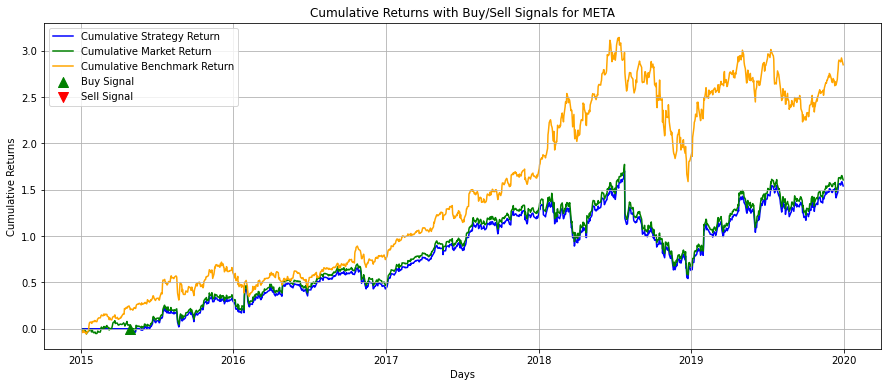

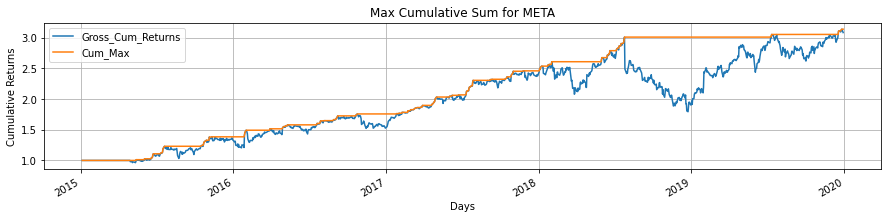

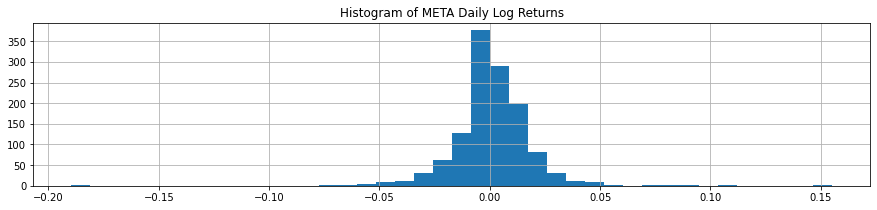

In [131]:
cumulative_returns_plot("META")
max_cumsum_plot("META")
hist_returns_plot("META")

Performance Analysis of META Strategy Returns vs Benchmark Returns

The strategy closely follows the market return (in blue) for most of the time. However, it underperforms the benchmark (in yellow), especially during strong upward trends, such as 2017–2019. This could suggest that while the strategy is relatively conservative and tracks the market, it fails to capture the same upside as the benchmark during more aggressive market movements.
The buy/sell signals misses capturing large gains (e.g., mid-2018). This could indicate that the exit rules (sell conditions) are too conservative, missing out on prolonged upward momentum. The strategy indeed lacks sell signals, with only 1 buy signal.

The histogram of META's daily log returns shows that the majority of returns are clustered around zero, with more small losses than small wins. It is also slightly skewed with a longer right tail, indicating that the strategy does capsture some upward trend but not with a significant edge.

The max drawdown is significant in 2018–2019, where the cumulative returns dip below their historical peak, indicating that even though the strategy is less volatile than the market, it’s not completely immune to large downturns.

## <font color = 'red'> 5.2.2 AAPL Cumulative returns and histogram of log returns

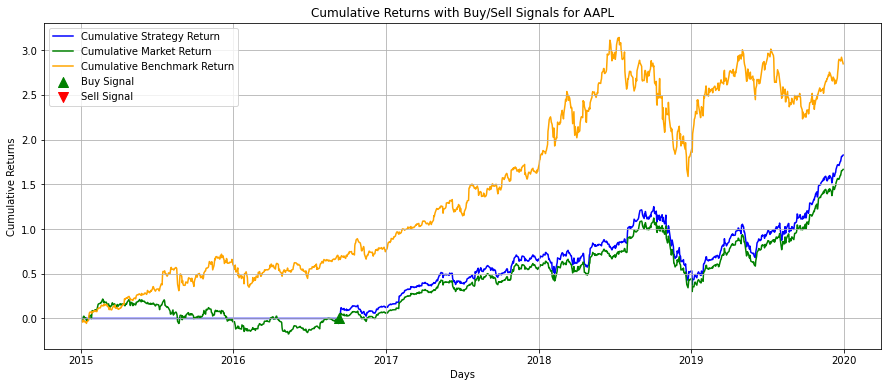

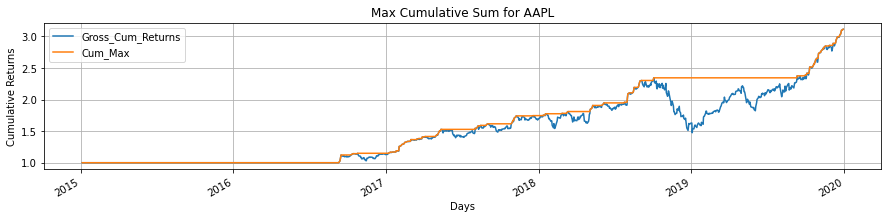

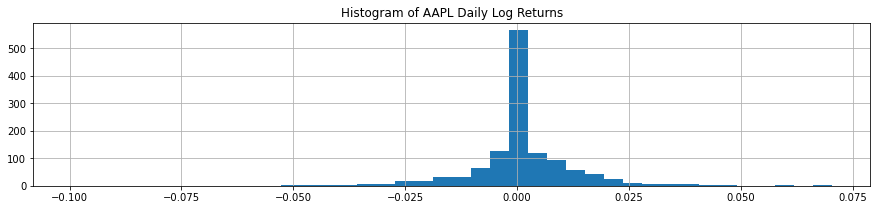

In [132]:
cumulative_returns_plot("AAPL")
max_cumsum_plot("AAPL")
hist_returns_plot("AAPL")

The strategy’s cumulative return (blue line) follows the market closely (green line) but underperforms compared to the benchmark return (yellow line). There is a lack of buy/sell signal, which reults in the failure to capsture the recovery phase of the bullish run from 2017-late 2018.

The strategy keeps a close match with the cumulative max for most of the time, suggesting that it recovers from downturns reasonably well but may not capitalize fully on sharp upward market movements. 

Similar to META, the AAPL daily log returns are concentrated around zero.
There are a few outliers on both the positive and negative ends, indicating some occasional high volatility but overall a controlled and balanced approach.
The skewed distribution with a positive tail suggests that the strategy captures some gains during bullish phases but is still relatively conservative in overall return capture.

## <font color = 'red'> 5.2.3 AMZN Cumulative returns and histogram of log returns

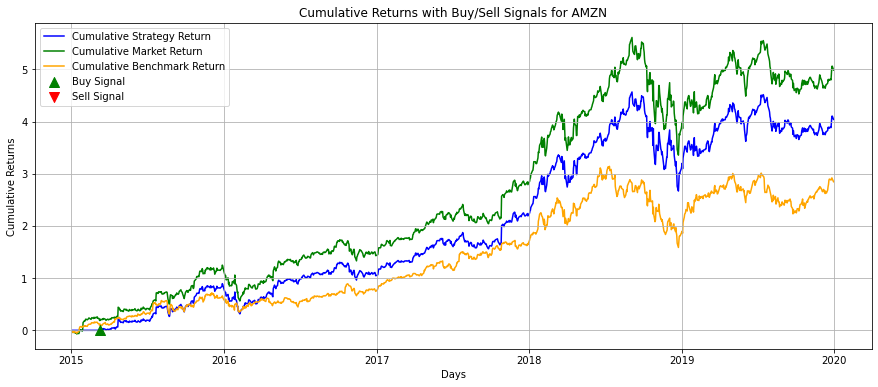

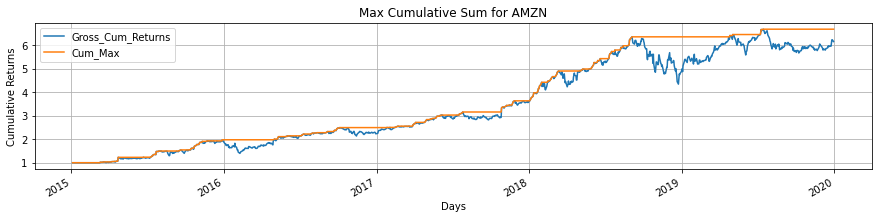

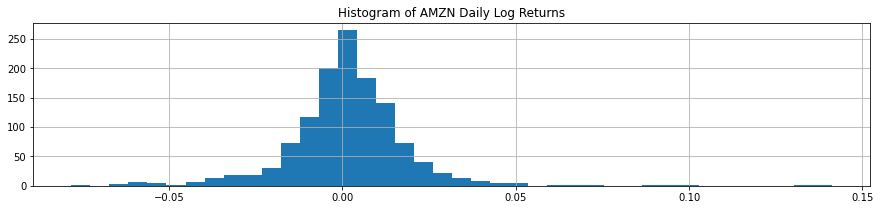

In [133]:
cumulative_returns_plot("AMZN")
max_cumsum_plot("AMZN")
hist_returns_plot("AMZN")

The strategy’s cumulative return (blue line) tracks the market return (green line) closely, showing effective participation in the market’s growth, especially during 2017-2018. The benchmark return (yellow line) lags significantly behind both the strategy and the market, indicating that AMZN performed exceptionally well during the observed period, outperforming typical market benchmarks. Similarly, there is a lack of buy/sell signals.

The strategy keeps a close match with the cumulative max for most of the time, From mid 2018 onward, there are noticeable dips in the cumulative return line, reflecting periods of market stress. 

The distribution of daily log returns for AMZN is concentrated around zero with a long right tail, indicating that the strategy captures significant positive returns on some days.

## <font color = 'red'> 5.2.4 NFLX Cumulative returns and histogram of log returns

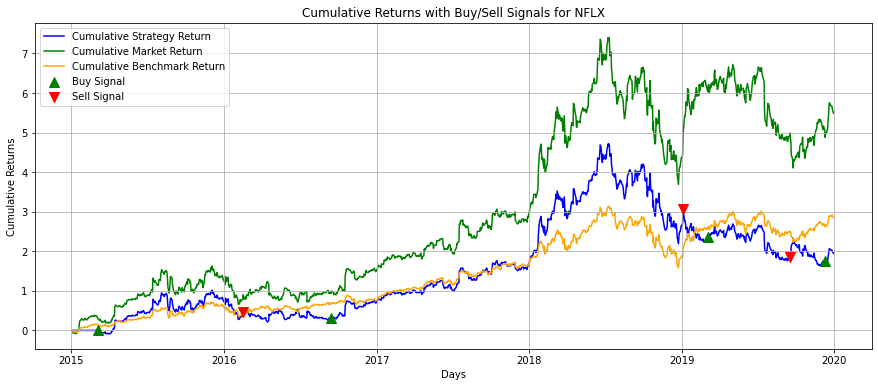

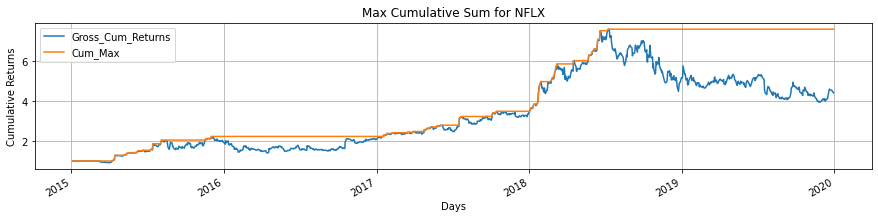

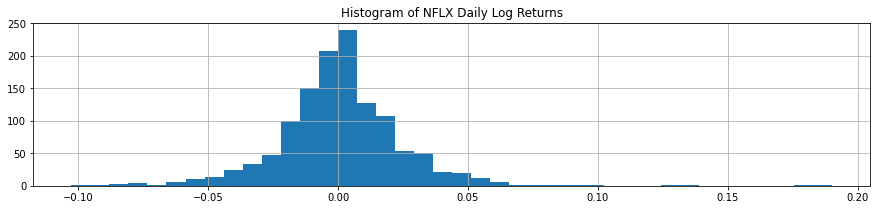

In [134]:
cumulative_returns_plot("NFLX")
max_cumsum_plot("NFLX")
hist_returns_plot("NFLX")

The strategy’s cumulative return (blue line) tracks the benchmark return (yellow line), showing effective participation in the market’s growth, especially during 2017-2018. From 2019 to 2019, the strategy performs better than the benchmark. The buy signals are timed well, as compared to sell signals, which lags in capturing market movement.

From mid 2018 onward, there are noticeable dips in the cumulative return line, and the strategy does not recover from the dip, this calls for better risk management and stop loss.

The distribution of daily log returns for AMZN is concentrated around zero with a long right tail, indicating that the strategy captures significant positive returns on some days.

## <font color = 'red'> 5.2.5 GOOGL Cumulative returns and histogram of log returns

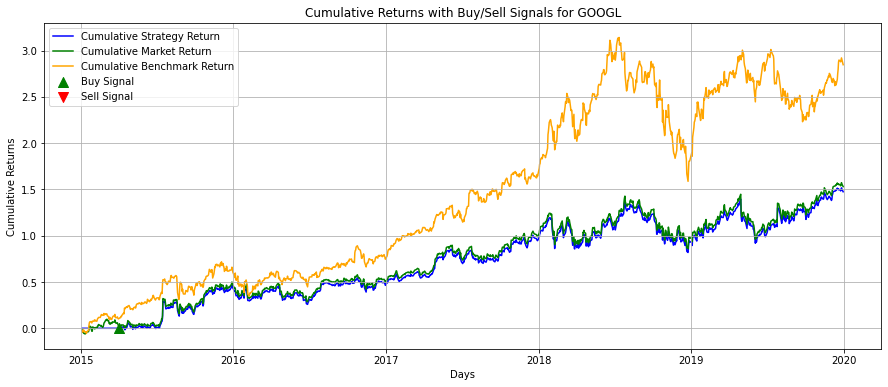

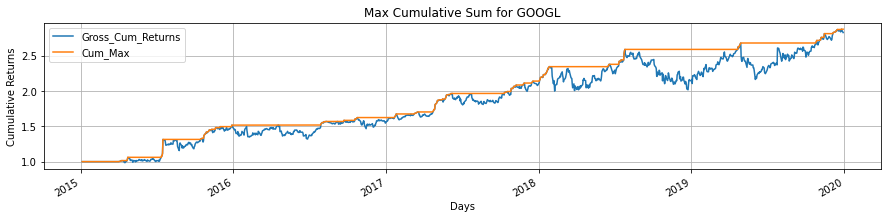

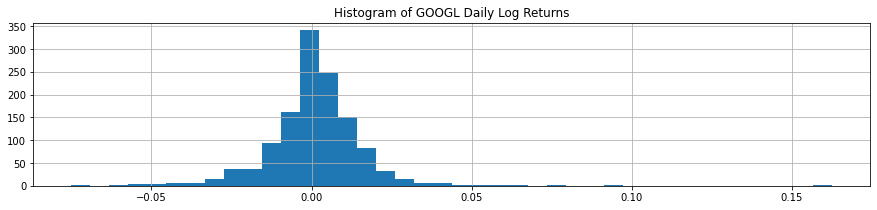

In [135]:
cumulative_returns_plot("GOOGL")
max_cumsum_plot("GOOGL")
hist_returns_plot("GOOGL")

The strategy’s cumulative return (blue line) tracks the market return (green line), showing effective participation in the market’s growth. The strategy underperforms as compared to the benchmark, and there is a lack of buy/sell signal, with no sell signals and only a single buy signal at the beginning of 2015.

From 2018 onward, there are noticeable dips in the cumulative return line, reflecting periods of market stress. It takes about half a year to 1 year for the strategy to recover, suggesting that better risk management should be included. 

The distribution of daily log returns for AMZN is concentrated around zero with a long right tail, indicating that the strategy captures significant positive returns on some days.

# <font color = 'red'> 5.3 Interactable Version of Cumulative Returns </font>

In [136]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go

app = dash.Dash(__name__)

# Dropdown options for stock selection
stock_options = [{'label': stock, 'value': stock} for stock in stockList.keys()]

# App layout
app.layout = html.Div(style={'display': 'flex', 'flexDirection': 'column', 'height': '100vh', 'padding': '10px'}, children=[
    # Dropdown to select a stock
    dcc.Dropdown(
        id='stock-dropdown',
        options=stock_options,
        value=list(stockList.keys())[0], 
        clearable=False,
        style={'width': '100%'}
    ),
    
    # Graph for cumulative returns
    dcc.Graph(
        id='cumulative-returns',
        style={'flex': '1', 'height': '50vh'}  # Take up half of the viewport height
    ),
    
    # Graph for max cumulative sum
    dcc.Graph(
        id='max-cumulative-sum',
        style={'flex': '1', 'height': '50vh'}  # Take up half of the viewport height
    )
])

# Callback to update the graphs when the dropdown value changes
@app.callback(
    [Output('cumulative-returns', 'figure'), Output('max-cumulative-sum', 'figure')],
    [Input('stock-dropdown', 'value')]
)
def update_graphs(selected_stock):
    # Get the data for the selected stock
    bt_data = stockList[selected_stock]['strat']
    bt_data = calculate_returns(bt_data)
    
    # Cumulative returns figure
    cumulative_returns_figure = {
        'data': [
            go.Scatter(x=bt_data.index, y=bt_data['Cumulative_Strategy_Return'], mode='lines', name='Cumulative Strategy Return', line=dict(color='blue')),
            go.Scatter(x=bt_data.index, y=bt_data['Cumulative_Market_Return'], mode='lines', name='Cumulative Market Return', line=dict(color='orange'))
        ],
        'layout': go.Layout(
            title=f'Cumulative Returns for {selected_stock}',
            xaxis_title='Days',
            yaxis_title='Cumulative Returns',
            hovermode='x'
        )
    }
    
    # Max cumulative sum figure
    max_cumulative_sum_figure = {
        'data': [
            go.Scatter(x=bt_data.index, y=bt_data['Gross_Cum_Returns'], mode='lines', name='Gross Cumulative Returns', line=dict(color='green')),
            go.Scatter(x=bt_data.index, y=bt_data['Cum_Max'], mode='lines', name='Cumulative Maximum', line=dict(color='red'))
        ],
        'layout': go.Layout(
            title=f'Max Cumulative Sum for {selected_stock}',
            xaxis_title='Days',
            yaxis_title='Cumulative Returns',
            hovermode='x'
        )
    }
    
    return cumulative_returns_figure, max_cumulative_sum_figure

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


# <font color = 'red'> 5.4 Benchmark Cumulative Returns vs Porfolio Returns </font>

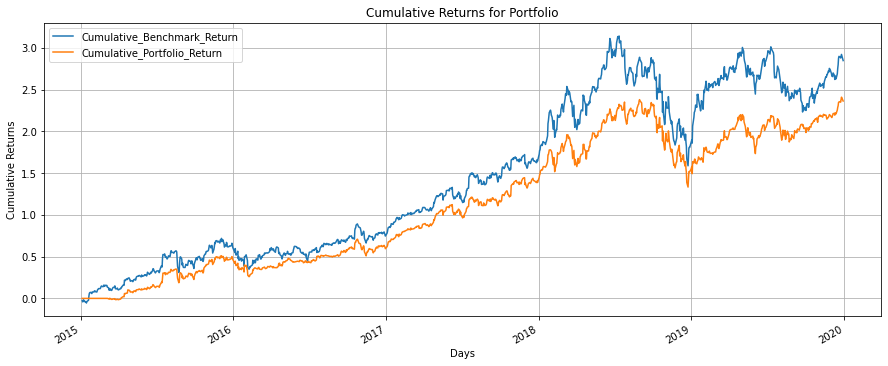

In [137]:
benchmark[["Cumulative_Benchmark_Return", "Cumulative_Portfolio_Return"]].plot(figsize=(15, 6))
plt.title(f'Cumulative Returns for Portfolio')
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

In [172]:
print(benchmark['Cumulative_Benchmark_Return'][-1])

print(benchmark['Cumulative_Portfolio_Return'][-1])

2.847073419477326
2.363001477016283


The cumulative returns graph reveals that the strategy (yellow) consistently underperformed compared to the benchmark returns (blue), indicating that the strategy did not effectively capture market gains. T
However, the primary trend of the strategy and the benchmark is consistent, indicating that the strategy is able to capture the overall trend of the market.

# <font color = 'red'> 6. Performance Metrics</font>

In [138]:
def sharpe_ratio(data, risk_free_rate=0.0):
    """Calculate the Sharpe ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    return np.sqrt(252) * excess_return.mean() / excess_return.std()

def sortino_ratio(data, risk_free_rate=0.0):
    """Calculate the Sortino ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    negative_return = data['Strategy_Return'][data['Strategy_Return'] < 0]
    downside_deviation = np.std(negative_return) * np.sqrt(252)
    return (excess_return.mean() * 252) / downside_deviation

def treynor_ratio(data, beta, risk_free_rate=0.0):
    """Calculate the Treynor ratio of the strategy."""
    excess_return = data['Strategy_Return'] - risk_free_rate / 252
    return (excess_return.mean() * 252) / beta

def max_drawdown(data):
    """Calculate the maximum drawdown of the strategy."""
    cumulative = (data['Strategy_Return'] + 1).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

def tracking_error(data):
    """Calculate the tracking error of the strategy vs. the benchmark."""
    active_return = data['Strategy_Return'] - data['Market_Return']
    return np.std(active_return) * np.sqrt(252)

def information_ratio(data):
    """Calculate the information ratio of the strategy vs. the benchmark."""
    active_return = data['Strategy_Return'] - data['Market_Return']
    return (active_return.mean() * 252) / tracking_error(data)

def beta(data):
    """Calculate the beta of the strategy against the benchmark."""
    covariance = data[['Strategy_Return', 'Market_Return']].cov().iloc[0, 1]
    variance_market = data['Market_Return'].var()
    return covariance / variance_market

def alpha(data, risk_free_rate=0.00):
    """Calculate the alpha of the strategy against the benchmark."""
    beta_value = beta(data)
    market_return_annualized = data['Market_Return'].mean() * 252
    strategy_return_annualized = data['Strategy_Return'].mean() * 252
    return strategy_return_annualized - (risk_free_rate + beta_value * (market_return_annualized - risk_free_rate))

def standard_deviation(data):
    """Calculate the annualized standard deviation of the strategy returns."""
    return data['Strategy_Return'].std() * (252 ** 0.5)

def annual_returns(data):
    daily_log_returns = data['Strategy_Return'].mean()
    annual_log_returns = daily_log_returns * 252

    # Convert to annualized regular returns
    annual_regular_returns = np.exp(annual_log_returns) - 1
    return annual_regular_returns

def benchmark_returns():
    meta1 = dd[meta]
    aapl1 = dd[apple]
    amzn1 = dd[amazon]
    googl1 = dd[google]
    nflx1 = dd[netflix]

    logmeta = 0.2 * np.log(meta1 / meta1.shift(1))
    logaapl = 0.2 * np.log(aapl1 / aapl1.shift(1))
    logamzn = 0.2 * np.log(amzn1 / amzn1.shift(1))
    loggoogl = 0.2 * np.log(googl1 / googl1.shift(1))
    lognflx = 0.2 * np.log(nflx1 / nflx1.shift(1))

    tgt = logmeta + logaapl + logamzn + loggoogl + lognflx
    tgt = tgt.dropna()

    return np.exp(tgt.mean() * 252) -1



In [178]:
def calculate_performance_metrics(stock):
	bt_data = stockList[stock]['strat']
	sharpe = sharpe_ratio(bt_data)
	sortino = sortino_ratio(bt_data)
	betaInfo = beta(bt_data)
	treynor = treynor_ratio(bt_data, betaInfo)
	maxDrawdown = max_drawdown(bt_data)
	trackingError = tracking_error(bt_data)
	informationRatio = information_ratio(bt_data)
	alphaInfo = alpha(bt_data)
	stddev = standard_deviation(bt_data)
	annual_return = annual_returns(bt_data)
	benchmark_annual_returns = benchmark_returns()

	print(f"--- Performance Metrics for {stock}")
	print(f"Beta: {betaInfo:.4f}")
	print(f"Alpha: {alphaInfo:.4f}")

	print(f"Sharpe Ratio: {sharpe:.4f}")
	print(f"Standard Deviation: {stddev:.4f}")
	print(f"Annual Returns: {annual_return:.4f}")
	print(f"Benchmark Annual Returns: {benchmark_annual_returns:.4f}")

	print(f"Sortino Ratio: {sortino:.4f}")
	print(f"Treynor Ratio: {treynor:.4f}")
	print(f"Max Drawdown: {maxDrawdown:.4f}")
	print(f"Tracking Error: {trackingError:.4f}")
	print(f"Information Ratio: {informationRatio:.4f}")
	print("\n")


## <font color = 'red'> 6.1 META Performance Metrics

In [140]:
calculate_performance_metrics("META")

--- Performance Metrics for META
Beta: 0.9627
Alpha: 0.0021
Sharpe Ratio: 0.8150
Standard Deviation: 0.2770
Annual Returns: 0.2533
Benchmark Annual Returns: 0.2993
Sortino Ratio: 0.9991
Treynor Ratio: 0.1881
Max Drawdown: -0.4296
Tracking Error: 0.0545
Information Ratio: -0.1208




Performance Summary for META Strategy

The META strategy achieved an annualized return of 25.33%, which remains lower than the benchmark's return of 29.93 The Sharpe ratio of 0.8150 suggests that the strategy provided only a above moderate reward per unit of risk taken Furthermore, the positive alpha of 0.0021 implies that while the strategy did add some value compared to the benchmark, it still fell short in effectively leveraging the stock's growth, reflecting inefficiencies in the execution of its buy and sell signals. The max drawdown is -0.4296, which is quite significant, this shows that the strategy could be improved by implementing stop loss measures.

## <font color = 'red'> 6.2 AAPL Performance Metrics

In [141]:
calculate_performance_metrics("AAPL")

--- Performance Metrics for AAPL
Beta: 0.6265
Alpha: 0.0852
Sharpe Ratio: 1.1581
Standard Deviation: 0.1969
Annual Returns: 0.2561
Benchmark Annual Returns: 0.2993
Sortino Ratio: 1.2398
Treynor Ratio: 0.1900
Max Drawdown: -0.3873
Tracking Error: 0.1519
Information Ratio: 0.0010




The AAPL strategy achieved a sharpe ratio of 1.1581, which indicates that it provides a more than proportionate return per unit of risk. It also has an annual return of 0.2561, paired with the Alpha of 0.0852, shows that the strategy performs quite well. However, the max drawdown is -0.3873, which is quite significant, this shows that the strategy could be improved by implementing stop loss measures.

## <font color = 'red'> 6.3 AMZN Performance Metrics

In [152]:
calculate_performance_metrics("AMZN")

--- Performance Metrics for AMZN
Beta: 0.9319
Alpha: -0.0099
Sharpe Ratio: 1.2892
Standard Deviation: 0.2826
Annual Returns: 0.4395
Benchmark Annual Returns: 0.2993
Sortino Ratio: 1.8121
Treynor Ratio: 0.3036
Max Drawdown: -0.3410
Tracking Error: 0.0767
Information Ratio: -0.4858




AMZN has a sharpe ratio of 1.2892 and annual returns of 0.4395, this shows that the strategy on AMZN does well as compared to the benchmark, and also performs well per unit of risk. However, it has a negative alpha of -0.0099, which shows that after accounting for market risk, the strategy underperforms the benchmark. It also has a max drawdown of -0.3410, which is quite significant.

## <font color = 'red'> 6.4 NFLX Performance Metrics

In [153]:
calculate_performance_metrics("NFLX")

--- Performance Metrics for NFLX
Beta: 0.6208
Alpha: 0.0115
Sharpe Ratio: 0.7332
Standard Deviation: 0.4061
Annual Returns: 0.3468
Benchmark Annual Returns: 0.2993
Sortino Ratio: 1.1619
Treynor Ratio: 0.2481
Max Drawdown: -0.5381
Tracking Error: 0.3505
Information Ratio: -0.4660




NFLX has a sharpe ratio of 0.7332, indicating moderate returns per unit of risk. It has an annual return of 0.3468, beating the benchmark of 0.2993, it also has an alpha of 0.0115. Howver, the strategy has an immense drawdown of -0.5381, indicating that more than half of the value was loss. This calls more better risk management measures and stop loss mechanisms.

## <font color = 'red'> 6.5 GOOGL Performance Metrics

In [154]:
calculate_performance_metrics("GOOGL")

--- Performance Metrics for GOOGL
Beta: 0.9548
Alpha: 0.0040
Sharpe Ratio: 0.8976
Standard Deviation: 0.2324
Annual Returns: 0.2320
Benchmark Annual Returns: 0.2993
Sortino Ratio: 1.2362
Treynor Ratio: 0.1739
Max Drawdown: -0.2340
Tracking Error: 0.0506
Information Ratio: -0.1123




GOOGL produced annual returns of 0.2320, which underperforms the benchmark. However, it does have a relatively high sharpe ratio of 0.8976 as well as positive alpha of 0.004. With a small max drawdown of -0.234, this shows that the strategy is relatively risk averse and conservative. Although it fails to outperform the benchmark, this strategy excels in risk management. 

# <font color = 'red'> 6.6 Calculating equal weights porfolio metrics </font>

Defining methods to help with portfolio performance evaluation

In [ ]:
portfolio_returns = benchmark['Portfolio_Return'].dropna()
benchmark_returns = benchmark['Benchmark_Return'].dropna()

In [27]:
# Annualize factor (252 trading days per year)
def annualize(factor, periods_per_year=252):
    return factor * np.sqrt(periods_per_year)

# Calculate standard deviation
def standard_deviation(returns):
    return np.std(returns)

# Calculate annual return
def annual_returns_portfolio(returns):
    cumulative_return = (1 + returns).prod() - 1
    return (1 + cumulative_return) ** (252 / len(returns)) - 1

# Calculate Sharpe Ratio
def sharpe_ratio_portfolio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

# Calculate Sortino Ratio
def sortino_ratio_portfolio(returns, risk_free_rate=0):
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns)
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / downside_std * np.sqrt(252)

# Calculate Treynor Ratio
def treynor_ratio_portfolio(returns, benchmark_returns, risk_free_rate=0):
    beta = np.cov(returns, benchmark_returns)[0, 1] / np.var(benchmark_returns)
    excess_returns = np.mean(returns) - risk_free_rate / 252
    return excess_returns / beta

# Calculate Max Drawdown
def max_drawdown_portfolio(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Calculate Tracking Error
def tracking_error_portfolio(returns, benchmark_returns):
    return np.std(returns - benchmark_returns)

# Calculate Information Ratio
def information_ratio_portfolio(returns, benchmark_returns):
    return np.mean(returns - benchmark_returns) / tracking_error(returns, benchmark_returns)

# Calculate Beta
def beta_portfolio(returns, benchmark_returns):
    covariance = np.cov(returns, benchmark_returns)[0, 1]
    benchmark_variance = np.var(benchmark_returns)
    return covariance / benchmark_variance

# Calculate Alpha
def alpha_portfolio(returns, benchmark_returns, risk_free_rate=0):
    beta_value = beta(returns, benchmark_returns)
    expected_returns = risk_free_rate / 252 + beta_value * (benchmark_returns.mean() - risk_free_rate / 252)
    return np.mean(returns) - expected_returns


# Example data (you can replace these with your actual returns data)
portfolio_returns = benchmark['Portfolio_Return'].dropna()
benchmark_returns = benchmark['Benchmark_Return'].dropna()

# Standard Deviation
stddev = standard_deviation(portfolio_returns)

# Annual Return
annual_return = annual_returns_portfolio(portfolio_returns)

# Sharpe Ratio
sharpe = sharpe_ratio_portfolio(portfolio_returns)

# Sortino Ratio
sortino = sortino_ratio_portfolio(portfolio_returns)

# Treynor Ratio
treynor = treynor_ratio_portfolio(portfolio_returns, benchmark_returns)

# Max Drawdown
max_drawdown_value = max_drawdown_portfolio(portfolio_returns)

# Tracking Error
tracking_error_value = tracking_error_portfolio(portfolio_returns, benchmark_returns)

# Information Ratio
information_ratio_value = information_ratio_portfolio(portfolio_returns, benchmark_returns)

# Beta
beta_value = beta_portfolio(portfolio_returns, benchmark_returns)

# Alpha
alpha_value = alpha_portfolio(portfolio_returns, benchmark_returns)

# Print Results
print(f"Standard Deviation: {stddev:.4f}")
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Treynor Ratio: {treynor:.4f}")
print(f"Max Drawdown: {max_drawdown_value:.4f}")
print(f"Tracking Error: {tracking_error_value:.4f}")
print(f"Information Ratio: {information_ratio_value:.4f}")
print(f"Beta: {beta_value:.4f}")
print(f"Alpha: {alpha_value:.4f}")


Standard Deviation: 0.0130
Annual Return: 0.2755
Sharpe Ratio: 1.2799
Sortino Ratio: 1.6205
Treynor Ratio: 0.0015
Max Drawdown: -0.3098
Tracking Error: 0.0079
Information Ratio: -0.0200
Beta: 0.6998
Alpha: 0.0002


<hr>

# <font color = 'red'> Appendix (Variant 1) </font>

In [142]:
pd.options.mode.chained_assignment = None

#Run the strategy for each MAANG stock
for stock in defaultStockList:
    defaultStockList[stock]['strat'] = strategy(stock, 200, 20, 2)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# <font color = 'red'> 1. Default Buy/Sell Signals </font>

META ================================================


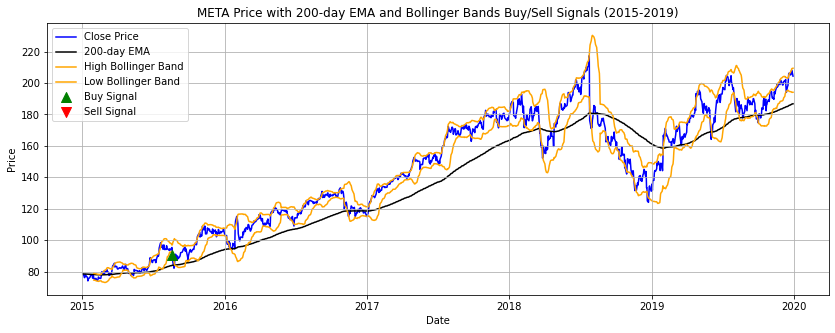

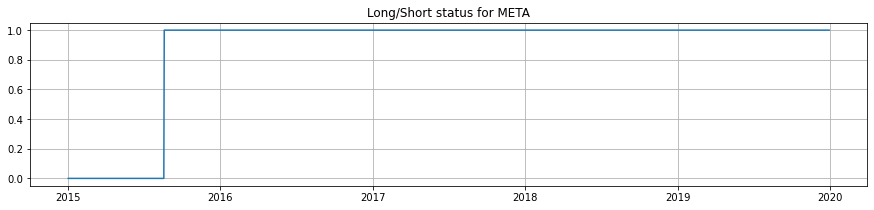

AMZN ================================================


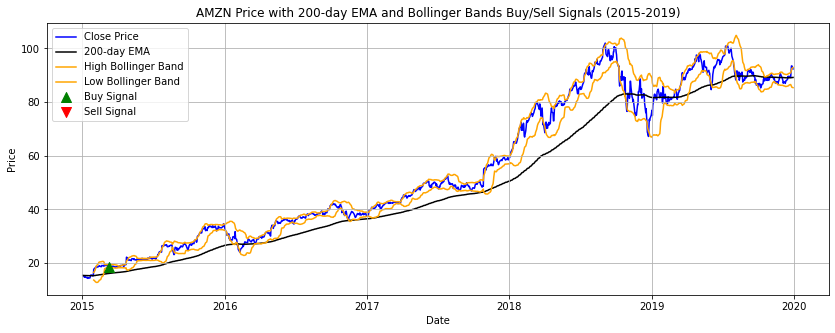

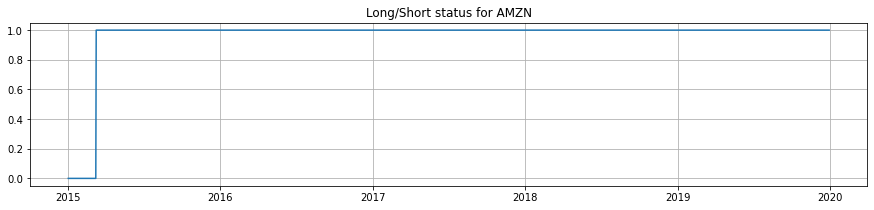

AAPL ================================================


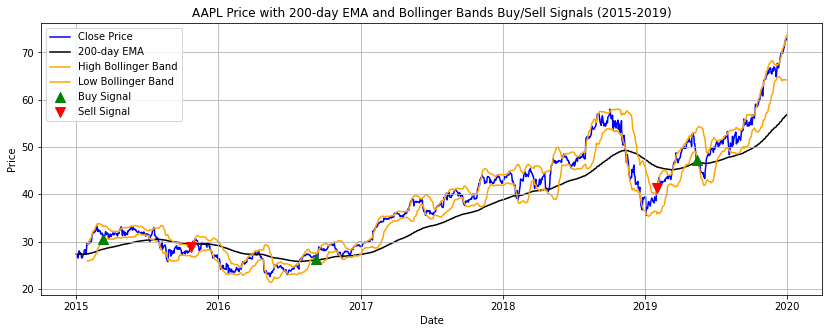

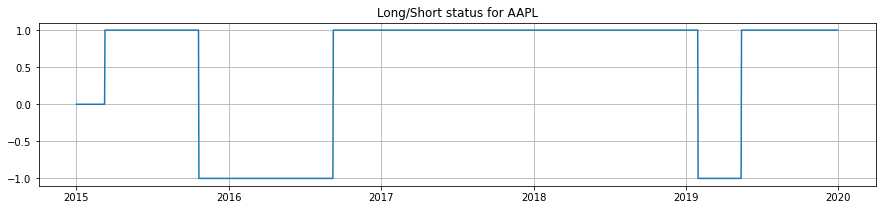

NFLX ================================================


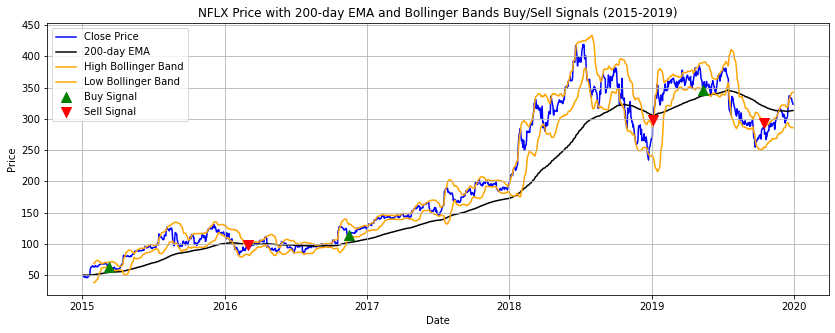

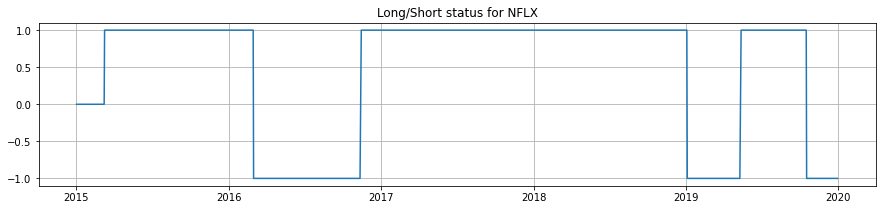

GOOGL ================================================


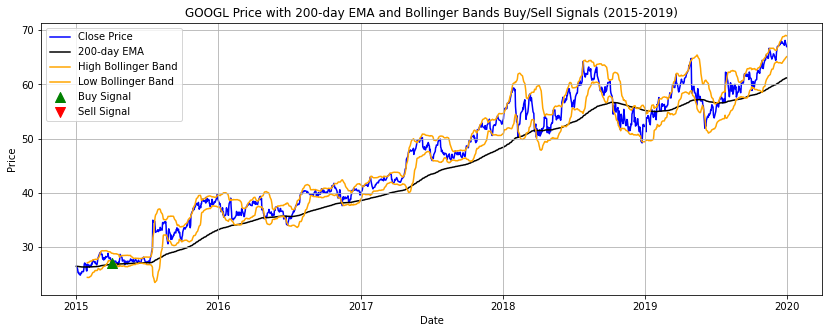

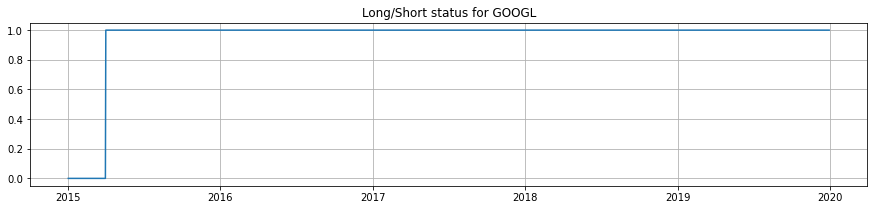

In [143]:
for stock in defaultStockList:
	print(f"{stock} ================================================")
	# Visualization of price, 200-day EMA, and buy/sell signals
	plt.figure(figsize=(14, 5))
	plt.plot(defaultStockList[stock]['strat']['Close'], label='Close Price', color='blue', zorder=1)
	plt.plot(defaultStockList[stock]['strat']['EMA'], label='200-day EMA', color='black', zorder=1)
	plt.plot(defaultStockList[stock]['strat']['bb_high'], label='High Bollinger Band', color='orange', zorder=1)
	plt.plot(defaultStockList[stock]['strat']['bb_low'], label='Low Bollinger Band', color='orange', zorder=1)
	#plt.plot(stockList[google]['strat']['bb_mid'], label='20 Day Moving Average', color='black')

	buy_signals = defaultStockList[stock]['strat'][(defaultStockList[stock]['strat']['Position'] == 1) & (defaultStockList[stock]['strat']['Position'].shift(1) != 1)]

	plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100, zorder=2)

	# Plot Sell signals (MACD cross above zero and price below 200 EMA)
	sell_signals = defaultStockList[stock]['strat'][(defaultStockList[stock]['strat']['Position'] == -1) & (defaultStockList[stock]['strat']['Position'].shift(1) != -1)]
	plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100, zorder=2)

	plt.title(f'{stock} Price with 200-day EMA and Bollinger Bands Buy/Sell Signals (2015-2019)')
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.legend()
	plt.grid()
	plt.show()

	bt_data = defaultStockList[stock]['strat']
	plt.figure(figsize=(15, 3))
	plt.plot(bt_data["Position"])
	plt.title(f"Long/Short status for {stock}")
	plt.grid()
	plt.show()

# <font color = 'red'> 2. Default Cumulative Returns and Histogram of Log Returns </font>

In [144]:
# Set up benchmark and plot cumulative returns with buy/sell signals

def default_cumulative_returns_plot(stock):
    bt_data = defaultStockList[stock]['strat']
    bt_data = calculate_returns(bt_data)
    bt_data['Cumulative_Benchmark_Return'] = benchmark['Cumulative_Benchmark_Return']
    
    # Cumulative returns plot
    plt.figure(figsize=(15, 6))
    plt.plot(bt_data['Cumulative_Strategy_Return'], label='Cumulative Strategy Return', color='blue', zorder=1)
    plt.plot(bt_data['Cumulative_Market_Return'], label='Cumulative Market Return', color='green', zorder=1)
    plt.plot(bt_data['Cumulative_Benchmark_Return'], label='Cumulative Benchmark Return', color='orange', zorder=1)
    
    # Add Buy signals
    buy_signals = bt_data[(bt_data['Position'] == 1) & (bt_data['Position'].shift(1) != 1)]
    plt.scatter(buy_signals.index, bt_data.loc[buy_signals.index, 'Cumulative_Strategy_Return'],
                marker='^', color='g', label='Buy Signal', s=100, zorder=2)

    # Add Sell signals
    sell_signals = bt_data[(bt_data['Position'] == -1) & (bt_data['Position'].shift(1) != -1)]
    plt.scatter(sell_signals.index, bt_data.loc[sell_signals.index, 'Cumulative_Strategy_Return'],
                marker='v', color='r', label='Sell Signal', s=100, zorder=2)

    # Plot labels, title, and legend
    plt.title(f'Cumulative Returns with Buy/Sell Signals for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid()
    plt.show()


def default_max_cumsum_plot(stock):
    bt_data = defaultStockList[stock]['strat']
    bt_data = calculate_returns(bt_data)
    # Max cumulative sum plot
    bt_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize=(15, 3))
    plt.title(f'Max Cumulative Sum for {stock}')
    plt.xlabel("Days")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()
    
def default_hist_returns_plot(stock):
    bt_data = defaultStockList[stock]['strat']
    bt_data = calculate_returns(bt_data)
    # Histogram of daily log returns
    plt.figure(figsize=(15, 3))
    plt.hist(bt_data["Strategy_Return"], bins=40)
    plt.title(f"Histogram of {stock} Daily Log Returns")
    plt.grid()
    plt.show()


## <font color = 'red'> 2.1 META Cumulative returns and histogram of log-returns before tuning

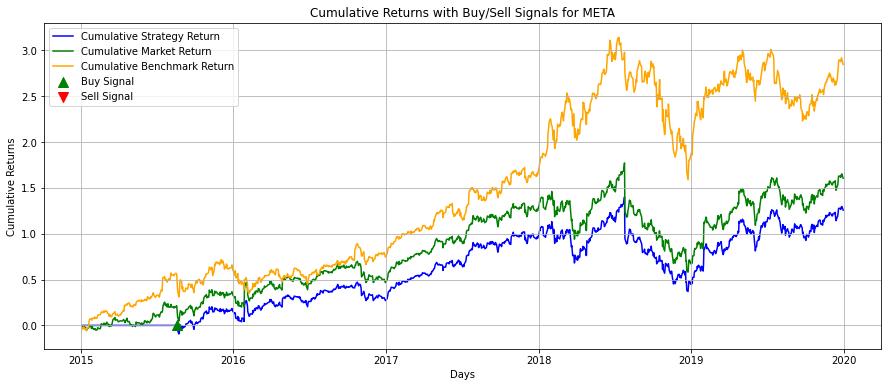

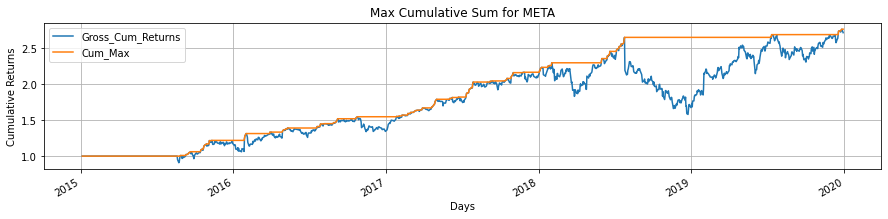

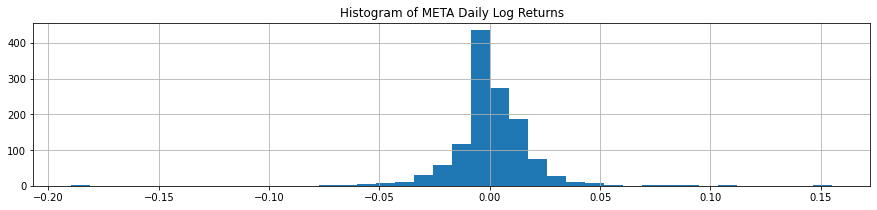

In [145]:
default_cumulative_returns_plot("META")
default_max_cumsum_plot("META")
default_hist_returns_plot("META")

Performance Analysis of META Strategy Returns vs Benchmark Returns Before Tuning

The strategy closely follows the market return (in blue) for most of the time. However, it underperforms the benchmark (in yellow), especially during strong upward trends, such as 2017–2019. This could suggest that while the strategy is relatively conservative and tracks the market, it fails to capture the same upside as the benchmark during more aggressive market movements.
The buy/sell signals misses capturing large gains (e.g., mid-2018). This could indicate that the exit rules (sell conditions) are too conservative, missing out on prolonged upward momentum. The strategy indeed lacks sell signals, with only 1 buy signal.

The histogram of META's daily log returns shows that the majority of returns are clustered around zero, with more small losses than small wins. It is also slightly skewed with a longer right tail, indicating that the strategy does capsture some upward trend but not with a significant edge.

The max drawdown is significant in 2018–2019, where the cumulative returns dip below their historical peak, indicating that even though the strategy is less volatile than the market, it’s not completely immune to large downturns.

## <font color = 'red'> 2.2 AAPL Cumulative returns and histogram of log-returns before tuning

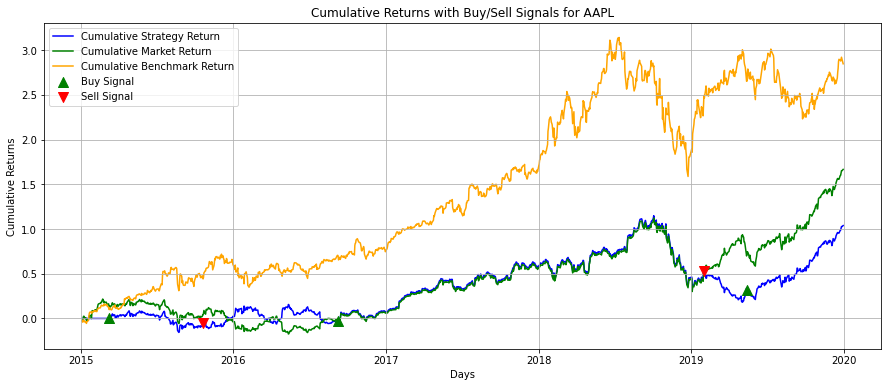

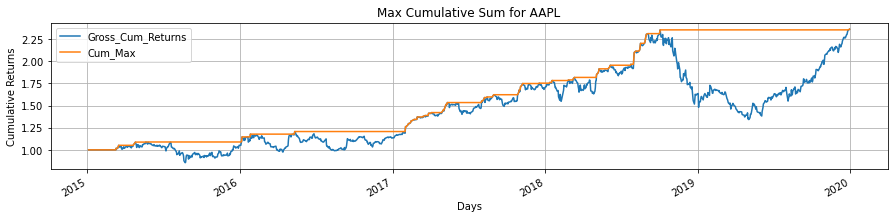

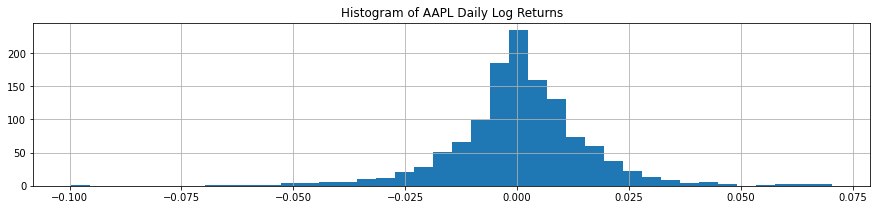

In [146]:
default_cumulative_returns_plot("AAPL")
default_max_cumsum_plot("AAPL")
default_hist_returns_plot("AAPL")

The strategy’s cumulative return (blue line) follows the market closely (green line) but underperforms compared to the benchmark return (yellow line). After 2019, the strategy underperforms for market due to false signals.

The strategy keeps a close match with the cumulative max for most of the time, until late 2018s, where the max drawdown occurs for more than a year. This shows that the strategy requires some tuning in order to reduce potential losses.

Similar to META, the AAPL daily log returns are concentrated around zero.
There are a few outliers on both the positive and negative ends, indicating some occasional high volatility but overall a controlled and balanced approach.

## <font color = 'red'> 2.3 AMZN Cumulative returns and histogram of log-returns before tuning

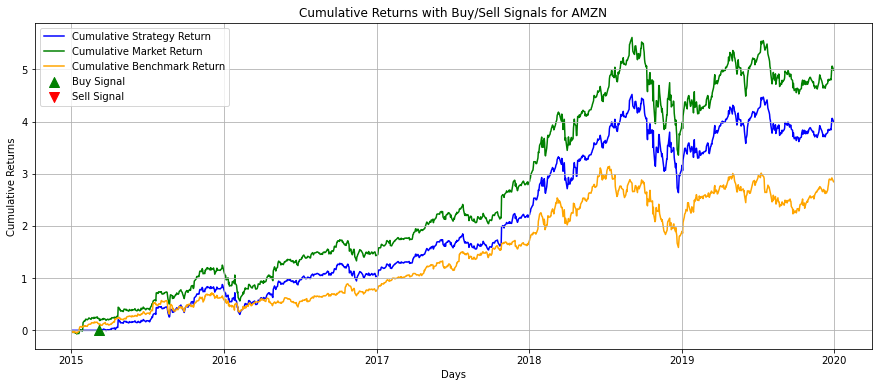

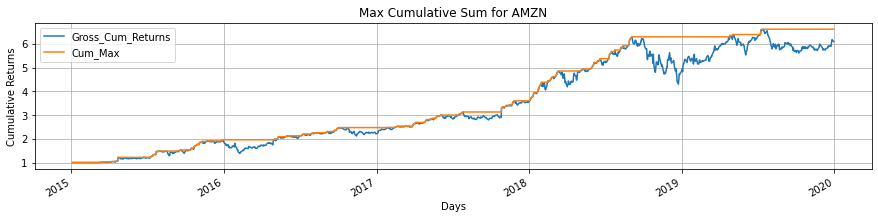

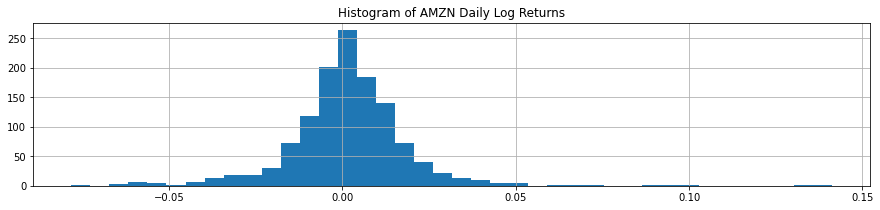

In [147]:
default_cumulative_returns_plot("AMZN")
default_max_cumsum_plot("AMZN")
default_hist_returns_plot("AMZN")

The strategy’s cumulative return (blue line) tracks the market return (green line) closely, showing effective participation in the market’s growth, especially during 2017-2018. The benchmark return (yellow line) lags significantly behind both the strategy and the market, indicating that AMZN performed exceptionally well during the observed period, outperforming typical market benchmarks. Similarly, there is a lack of buy/sell signals.

The strategy keeps a close match with the cumulative max for most of the time, From mid 2018 onward, there are noticeable dips in the cumulative return line, reflecting periods of market stress. 

The distribution of daily log returns for AMZN is concentrated around zero with a long right tail, indicating that the strategy captures significant positive returns on some days.

## <font color = 'red'> 2.4 NFLX Cumulative returns and histogram of log-returns before tuning

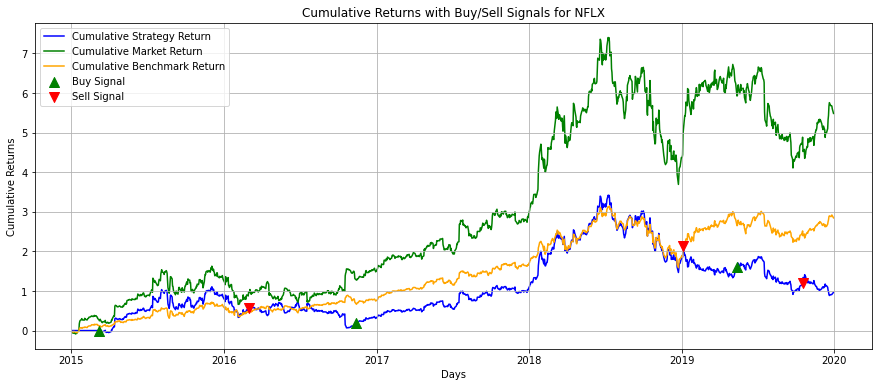

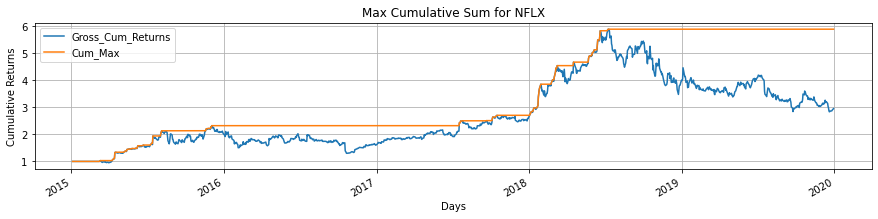

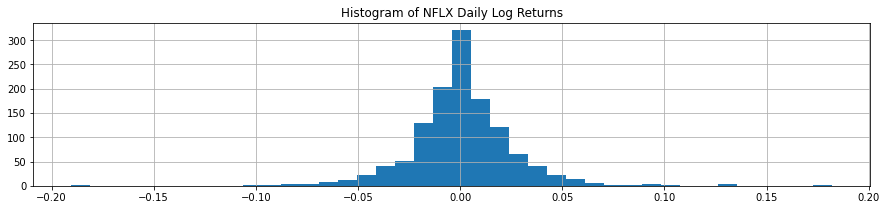

In [148]:
default_cumulative_returns_plot("NFLX")
default_max_cumsum_plot("NFLX")
default_hist_returns_plot("NFLX")

The strategy’s cumulative return (blue line) tracks the benchmark return (yellow line), showing effective participation in the market’s growth, especially during 2017-2018. From 2019 to 2019, the strategy performs better than the benchmark. The buy signals are timed well, as compared to sell signals, which lags in capturing market movement.

From mid 2018 onward, there are noticeable dips in the cumulative return line, and the strategy does not recover from the dip, this calls for better risk management and stop loss.

The distribution of daily log returns for AMZN is concentrated around zero with a long right tail, indicating that the strategy captures significant positive returns on some days.

## <font color = 'red'> 2.5 GOOGL Cumulative returns and histogram of log-returns before tuning

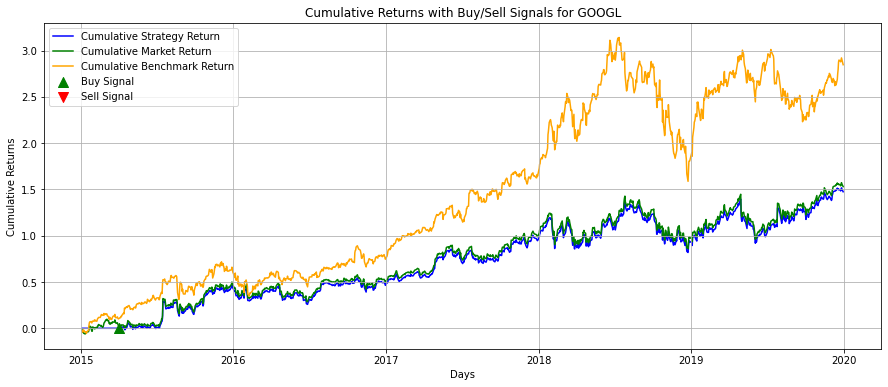

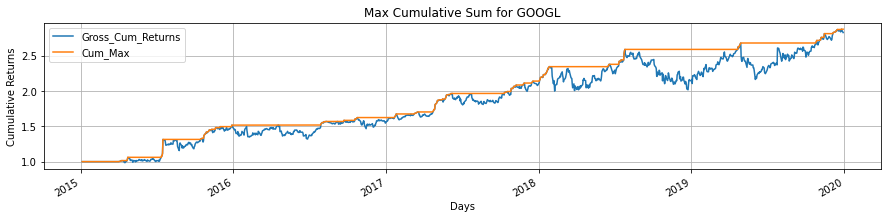

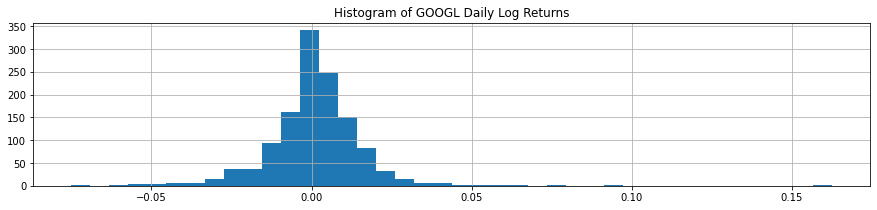

In [149]:
default_cumulative_returns_plot("GOOGL")
default_max_cumsum_plot("GOOGL")
default_hist_returns_plot("GOOGL")

# <font color = 'red'> 3. Benchmark vs Portfolio Cumulative Returns </font>

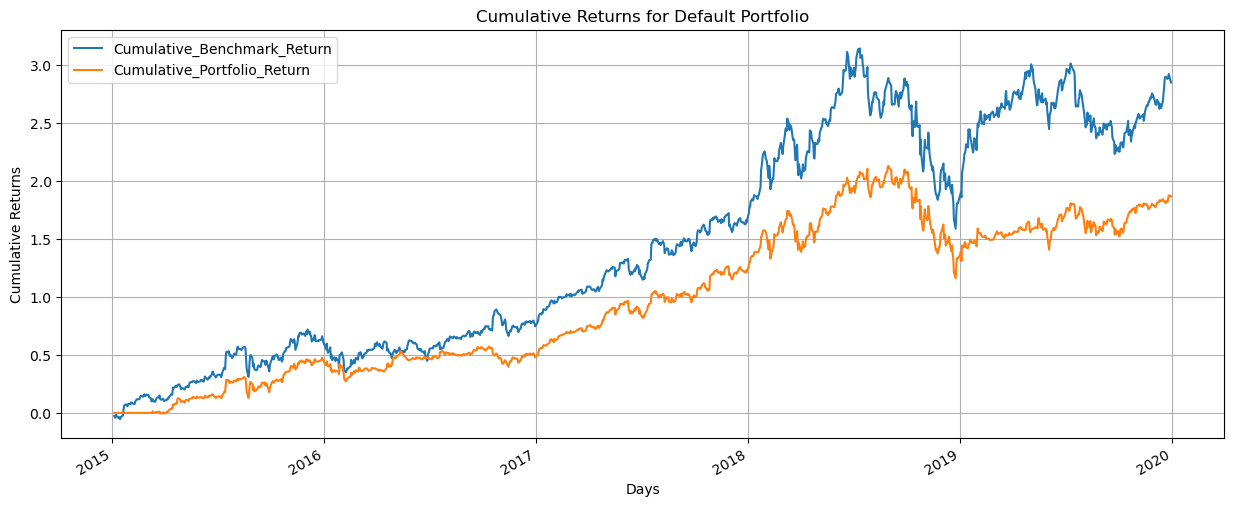

In [25]:
import copy
benchmark_default = copy.deepcopy(benchmark)

benchmark_default['Portfolio_Return'] = 0.2 * calculate_returns(defaultStockList[meta]['strat'])['Strategy_Return'] + 0.2 * calculate_returns(defaultStockList[amazon]['strat'])['Strategy_Return'] + \
	0.2 * calculate_returns(defaultStockList[apple]['strat'])['Strategy_Return'] + 0.2 * calculate_returns(defaultStockList[netflix]['strat'])['Strategy_Return'] + \
		0.2 * calculate_returns(defaultStockList[google]['strat'])['Strategy_Return']
	
benchmark_default['Cumulative_Portfolio_Return'] = (benchmark_default['Portfolio_Return'] + 1).cumprod() - 1

benchmark_default[["Cumulative_Benchmark_Return", "Cumulative_Portfolio_Return"]].plot(figsize=(15, 6))
plt.title(f'Cumulative Returns for Default Portfolio')
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()


# <font color = 'red'> 4. Default Performance Metrics </font>

In [159]:
def calculate_default_performance_metrics(stock):
	bt_data = defaultStockList[stock]['strat']
	sharpe = sharpe_ratio(bt_data)
	sortino = sortino_ratio(bt_data)
	treynor = treynor_ratio(bt_data, beta=1.2)
	maxDrawdown = max_drawdown(bt_data)
	trackingError = tracking_error(bt_data)
	informationRatio = information_ratio(bt_data)
	betaInfo = beta(bt_data)
	alphaInfo = alpha(bt_data)
	stddev = standard_deviation(bt_data)
	annual_return = annual_returns(bt_data)
	benchmark_annual_returns = benchmark_returns()

	print(f"--- Performance Metrics for {stock}")
	print(f"Beta: {betaInfo:.4f}")
	print(f"Alpha: {alphaInfo:.4f}")

	print(f"Sharpe Ratio: {sharpe:.4f}")
	print(f"Standard Deviation: {stddev:.4f}")
	print(f"Annual Returns: {annual_return:.4f}")
	print(f"Benchmark Annual Returns: {benchmark_annual_returns:.4f}")

	print(f"Sortino Ratio: {sortino:.4f}")
	print(f"Treynor Ratio: {treynor:.4f}")
	print(f"Max Drawdown: {maxDrawdown:.4f}")
	print(f"Tracking Error: {trackingError:.4f}")
	print(f"Information Ratio: {informationRatio:.4f}")
	print("\n")


## <font color = 'red'> 4.1 META performance metrics before tuning

In [160]:
calculate_default_performance_metrics("META")

--- Performance Metrics for META
Beta: 0.9142
Alpha: -0.0123
Sharpe Ratio: 0.7412
Standard Deviation: 0.2700
Annual Returns: 0.2215
Benchmark Annual Returns: 0.2993
Sortino Ratio: 0.8689
Treynor Ratio: 0.1668
Max Drawdown: -0.4296
Tracking Error: 0.0828
Information Ratio: -0.3891




META underperforms the benchmark returns with a lower annual returns of 0.2215 and a negative alpha of -0.0123. It also has max drawdown of -0.4296, which is quite large. The strategy could potentially perform better after tuning the parameters.

## <font color = 'red'> 4.2 AAPL performance metrics before tuning

In [162]:
calculate_default_performance_metrics("AAPL")

--- Performance Metrics for AAPL
Beta: 0.4779
Alpha: 0.0635
Sharpe Ratio: 0.7106
Standard Deviation: 0.2425
Annual Returns: 0.1881
Benchmark Annual Returns: 0.2993
Sortino Ratio: 0.9495
Treynor Ratio: 0.1436
Max Drawdown: -0.4503
Tracking Error: 0.2480
Information Ratio: -0.2236




AAPL underperforms the benchmark in terms of annual returns, with only 0.1881. However, it does have a positive alpha of 0.0635, as well as a moderate sharpe ratio of 0.7106. It has a relatively large drawdown of -0.4503, which indicates poor risk management.

## <font color = 'red'> 4.3 AMZN performance metrics before tuning

In [163]:
calculate_default_performance_metrics("AMZN")

--- Performance Metrics for AMZN
Beta: 0.9321
Alpha: -0.0117
Sharpe Ratio: 1.2830
Standard Deviation: 0.2826
Annual Returns: 0.4370
Benchmark Annual Returns: 0.2993
Sortino Ratio: 1.8051
Treynor Ratio: 0.3022
Max Drawdown: -0.3410
Tracking Error: 0.0766
Information Ratio: -0.5087




AMZN has a negative alpha of -0.0117, however it has above benchmark returns of 0.4370. Its sharpe ratio is 1.2830, indicating a larger than proportionate return per unit of risk. It has a significant drawdown of -0.3410, which indicates poor risk management.

## <font color = 'red'> 4.4 NFLX performance metrics before tuning

In [164]:
calculate_default_performance_metrics("NFLX")

--- Performance Metrics for NFLX
Beta: 0.4949
Alpha: -0.0108
Sharpe Ratio: 0.5352
Standard Deviation: 0.4061
Annual Returns: 0.2428
Benchmark Annual Returns: 0.2993
Sortino Ratio: 0.7749
Treynor Ratio: 0.1811
Max Drawdown: -0.5733
Tracking Error: 0.4081
Information Ratio: -0.5973




NFLX produced lower returns than the benchmark, with a negative alpha of -0.0108. Its sharpe ratio is also relatively low, with 0.5352. It has a very large drawdown of -0.5733, which is not ideal.

## <font color = 'red'> 4.5 GOOGL performance metrics before tuning

In [165]:
calculate_default_performance_metrics("GOOGL")

--- Performance Metrics for GOOGL
Beta: 0.9548
Alpha: 0.0040
Sharpe Ratio: 0.8976
Standard Deviation: 0.2324
Annual Returns: 0.2320
Benchmark Annual Returns: 0.2993
Sortino Ratio: 1.2362
Treynor Ratio: 0.1739
Max Drawdown: -0.2340
Tracking Error: 0.0506
Information Ratio: -0.1123




GOOGL underperforms the market in terms of its annual returns, with 0.2320 compared to 0.2993 of that of the benchmark. The alpha is positive at 0.0040 with a moderately high sharpe ratio of 0.8976. The strategy also has a relatively small drawdown of -0.2340. 

# <font color = 'red'> 4.6 Calculating equal weights porfolio metrics </font>

In [28]:
# Example data (you can replace these with your actual returns data)
portfolio_returns_default = benchmark_default['Portfolio_Return'].dropna()
benchmark_returnss_default = benchmark_default['Benchmark_Return'].dropna()

# Standard Deviation
stddev = standard_deviation(portfolio_returns_default)

# Annual Return
annual_return = annual_returns_portfolio(portfolio_returns_default)

# Sharpe Ratio
sharpe = sharpe_ratio_portfolio(portfolio_returns_default)

# Sortino Ratio
sortino = sortino_ratio_portfolio(portfolio_returns_default)

# Treynor Ratio
treynor = treynor_ratio_portfolio(portfolio_returns_default, benchmark_returnss_default)

# Max Drawdown
max_drawdown_value = max_drawdown_portfolio(portfolio_returns_default)

# Tracking Error
tracking_error_value = tracking_error_portfolio(portfolio_returns_default, benchmark_returnss_default)

# Information Ratio
information_ratio_value = information_ratio_portfolio(portfolio_returns_default, benchmark_returnss_default)

# Beta
beta_value = beta_portfolio(portfolio_returns_default, benchmark_returnss_default)

# Alpha
alpha_value = alpha_portfolio(portfolio_returns_default, benchmark_returnss_default)

# Print Results
print(f"Standard Deviation: {stddev:.4f}")
print(f"Annual Return: {annual_return:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Sortino Ratio: {sortino:.4f}")
print(f"Treynor Ratio: {treynor:.4f}")
print(f"Max Drawdown: {max_drawdown_value:.4f}")
print(f"Tracking Error: {tracking_error_value:.4f}")
print(f"Information Ratio: {information_ratio_value:.4f}")
print(f"Beta: {beta_value:.4f}")
print(f"Alpha: {alpha_value:.4f}")

Standard Deviation: 0.0129
Annual Return: 0.2352
Sharpe Ratio: 1.1356
Sortino Ratio: 1.4390
Treynor Ratio: 0.0014
Max Drawdown: -0.3098
Tracking Error: 0.0091
Information Ratio: -0.0315
Beta: 0.6534
Alpha: 0.0001
